# Project(9) : Machine Learning with Spark

## 4. Regression Model on RDD(RandomForest, GradientBoostingTree)
---


### 0) Previous Settings
- Import some libraries
- Loading raw_data
- Extract functions

### 1) RandomForest
- Model training Function and Parameters
- Optimization of RandomForest Model
- Optimized Random Forest Model

### 2) Gradient-Boosted Tree
- Model training Function and Parameters
- Optimization of Gradient Boosted Tree Model
- Optimized Gradient Boosted Tree Model


### * Conclusion
---

## 0) Previous Settings
- Import some libraries
- Loading raw_data
- Extract functions

In [1]:
%pylab inline

import numpy as np
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel

raw_data=sc.textFile("/home/csxion/Desktop/project/data/p9_data_11_16_1q_sed.csv")
records=raw_data.map(lambda line:line.split(","))
records.first()

subway_dict=records.map(lambda r:r[0]).distinct().zipWithIndex().collectAsMap() # distinct 꼭 사용할 것
time_dict=records.map(lambda r:r[2]).distinct().zipWithIndex().collectAsMap()
#date_dict=records.map(lambda r:r[1]).distinct().zipWithIndex().collectAsMap()

# r[0] : subway station name // Category feature => binary vector
# r[1] : Date(Not used)
# r[2] : Time(5~23) # Category feature => binary vector

def check_error_float(data, econd, subt): #data가 equal_cond와 같을때, subt로 치환한다.
    if(data==econd):
        return subt
    else:
        return float(data)

def extract_features_linear(r): #line별
    name_vec=np.zeros(len(subway_dict)) # 역 이름에 대하여 카테고리 특징을 바이너리 벡터 형태로 변환한다.
    name_vec[subway_dict[r[0]]]=1
    time_vec=np.zeros(len(time_dict)) # 시간 데이터에 대하여(5~23) 카테고리 특징을 바이너리 벡터 형태로 변환한다.
    time_vec[time_dict[r[2]]]=1
    #numbers=np.array([float(r[i]) for i in range(3,len(r)-1)])
    #numbers=np.array([float(e) for e in r[3:]])
    for i in range(3,len(r)-1):
        r[i]=check_error_float(r[i], "#N/A", 0.0)
    numbers=np.array([float(d) for d in r[3:len(r)-1]])
    return np.concatenate((name_vec, time_vec, numbers)) # 역 + 시간 + 특징벡터 값으로 구성되는 numpy.array를 반환한다.
#flatMap을 사용할 필요가 없음

def extract_label(r):
    return float(r[len(r)-1]) # int는 소문자로 지정해야 함
#float

def extract_features_dt(r): # dt모델에 적용할 특징벡터를 추출하는 함수. 여기서는 바이너리 벡터를 생성하지 않는다.
    name=float(subway_dict[r[0]])
    time=float(time_dict[r[2]])
    for i in range(3,len(r)-1):
        r[i]=check_error_float(r[i], "#N/A", 0.0)
    numbers=np.array([float(d) for d in r[3:len(r)-1]])
    return np.concatenate((np.array([name, time]), numbers))

# np.concatenate 함수는 꼭 이중괄호를 해주어야 index 에러가 나지 않는다.
# extract_label 함수의 경우 linearRegression Model과 DecisionTree 모두 동일하게 사용한다

def squared_error(actual, pred):
    return (actual-pred)**2
def abs_error(actual,pred):
    return np.abs(actual-pred)
def squared_log_error(actual, pred):
    return (np.log(pred+1)-np.log(actual+1))**2

Populating the interactive namespace from numpy and matplotlib


In [2]:
#data=records.map(lambda r:LabeledPoint(extract_label(r), Vectors.dense(np.array(extract_features_linear(r)))))
#data.cache
data_dt=records.map(lambda r:LabeledPoint(extract_label(r), Vectors.dense(np.array(extract_features_dt(r)))))
data_dt.cache

(train_data_dt, test_data_dt) = data_dt.randomSplit([0.7, 0.3]) #training Data와 Test Data를 7 : 3의 비율로 나눈다
train_data_dt.cache
test_data_dt.cache

<bound method RDD.cache of PythonRDD[15] at RDD at PythonRDD.scala:48>

In [3]:
data_dt.first()

LabeledPoint(78.0, [39.0,12.0,0.077606673,0.420556606,0.414592146,0.820293973,0.553426589,0.549782942,0.99369488])

In [16]:
#LinearRegression 모델 테스트 메소드
"""
def evaluate(train, test, iterations, step, regParam, regType, intercept):
    model=LinearRegressionWithSGD.train(train, iterations, step, regParam=regParam, regType=regType, intercept=intercept)
    tp=test.map(lambda p:(p.label, model.predict(p.features)))
    rmsle=np.sqrt(tp.map(lambda p:squared_log_error(p[0], p[1])).mean())
    return rmsle
"""

'\ndef evaluate(train, test, iterations, step, regParam, regType, intercept):\n    model=LinearRegressionWithSGD.train(train, iterations, step, regParam=regParam, regType=regType, intercept=intercept)\n    tp=test.map(lambda p:(p.label, model.predict(p.features)))\n    rmsle=np.sqrt(tp.map(lambda p:squared_log_error(p[0], p[1])).mean())\n    return rmsle\n'

---
## 1) RandomForest Model based RDD
- 임의성(randomness)에 의해 서로 조금씩 다른 특성을 갖는 트리들로 구성
- 부트스트랩 샘플에 임의성을 더함
- 랜덤포레스트를 사용하게 되면 더 이상 어떤 과정을 통해 예측이 이뤄지는 지 알 수 없음(DT에서는 확인 가능)
- 여러 개의 의사결정트리를 만들고, 투표를 시켜 다수결로 결과를 확인

##### Bagging(Bootstrap Aggregation)
- Bagging은 Bias-Variance trade off 를 해결하기 위한 방법
- 전체 데이터를 전부 이용해서 학습시키는 것이 아니라 샘플의 결과물을 각 트리의 입력 값으로 넣어 학습
- (Bias : 예측의 정확도, Variance : 예측의 정확도가 들쭉날쭉하는 정도. 한쪽이 높아지면 한쪽이 낮아지는 관계)
- 데이터셋에서 랜덤하게 부분데이터를 뽑아 여러개의 데이터 subset으로 bias를 decision tree의 평균값으로 유지하면서도 variance를 줄이는 방법

##### Variable Randomize(Ensemble Learning)
- 파티션을 나눌 때 변수에 랜덤성을 부여
- 남아있는 모든 변수 중에서 최적의 변수를 선택하는 것이 아니라 변수 중 일부만 선택하고 그 일부 중에서 최적의 변수를 선택



[참고] Mycloud http://swalloow.tistory.com/92
[참고] 위키백과 https://ko.wikipedia.org/wiki/%EB%9E%9C%EB%8D%A4_%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8

### 1-1) Model training Function and Parameters

##### .trainRegressor(data, categoricalFeaturesInfo, numTrees, featureSubsetStrategy='auto', impurity='variance', maxDepth=4, maxBins=32, seed=None)[source]
##### Parameters:	
* data – Training dataset: RDD of LabeledPoint. Labels are real numbers.
* categoricalFeaturesInfo – Map storing arity of categorical features. An entry (n -> k) indicates that feature n is categorical with k categories indexed from 0: {0, 1, ..., k-1}.
* numTrees – Number of trees in the random forest.
* featureSubsetStrategy – Number of features to consider for splits at each node. Supported values: “auto”, “all”, “sqrt”, “log2”, “onethird”. If “auto” is set, this parameter is set based on numTrees: if numTrees == 1, set to “all”; if numTrees > 1 (forest) set to “onethird” for regression. (default: “auto”)
* impurity – Criterion used for information gain calculation. The only supported value for regression is “variance”. (default: “variance”)
* maxDepth – Maximum depth of tree (e.g. depth 0 means 1 leaf node, depth 1 means 1 internal node + 2 leaf nodes). (default: 4)
* maxBins – Maximum number of bins used for splitting features. (default: 32)
* seed – Random seed for bootstrapping and choosing feature subsets. Set as None to generate seed based on system time. (default: None)

### 1-2) Optimization of RandomForest Model

In [3]:
# RandomForest 모델 테스트 메소드
def evaluate_rf(train, test, numTrees, maxDepth, maxBins):
    model=RandomForest.trainRegressor(train, categoricalFeaturesInfo={}, numTrees=numTrees, featureSubsetStrategy="auto",
                                    impurity='variance', maxDepth=maxDepth, maxBins=maxBins)
    preds=model.predict(test.map(lambda p:p.features))
    actual=test.map(lambda p:p.label)
    tp=actual.zip(preds)
    rmse=np.sqrt(tp.map(lambda p:squared_error(p[0], p[1])).mean())
    return rmse

#### 1-2-1) Parameter : numTree

[3, 5, 10, 20, 30]
[2671.6307157662068, 2735.9859068271012, 2712.142255372341, 2735.0662661473957, 2731.0055255464613]


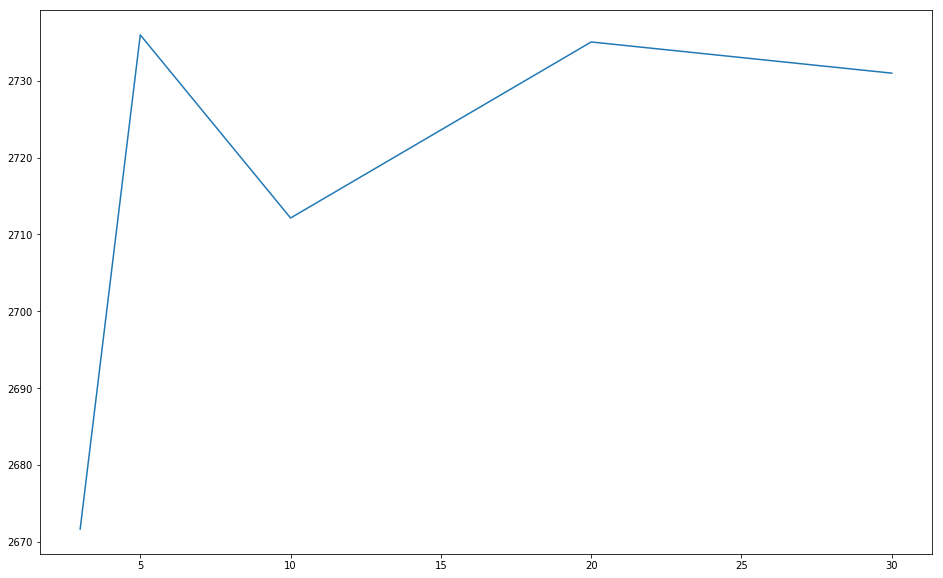

In [20]:
#numTree에 대한 관계 예측하기
params=[3,5,10,20,30]
metrics=[evaluate_rf(train_data_dt, test_data_dt, param, 4, 32) for param in params]
print(params)
print(metrics)
plot(params, metrics)
fig=matplotlib.pyplot.gcf()
fig.set_size_inches(16,10)

#실제로 data와 data_dt의 최적 결과값은 다르다. data를 대상으로 진행하였을때, optimized numTree=30

##### ∴ Optimized Value 'numTree' is 10

#### 1-2-2) Parameter : maxDepth

[2, 4, 5, 10, 20, 30]
[2832.5967063296953, 2755.2261403287471, 2688.9121680897561, 2456.3631812488225, 2317.3212826957865, 2446.0400846828052]


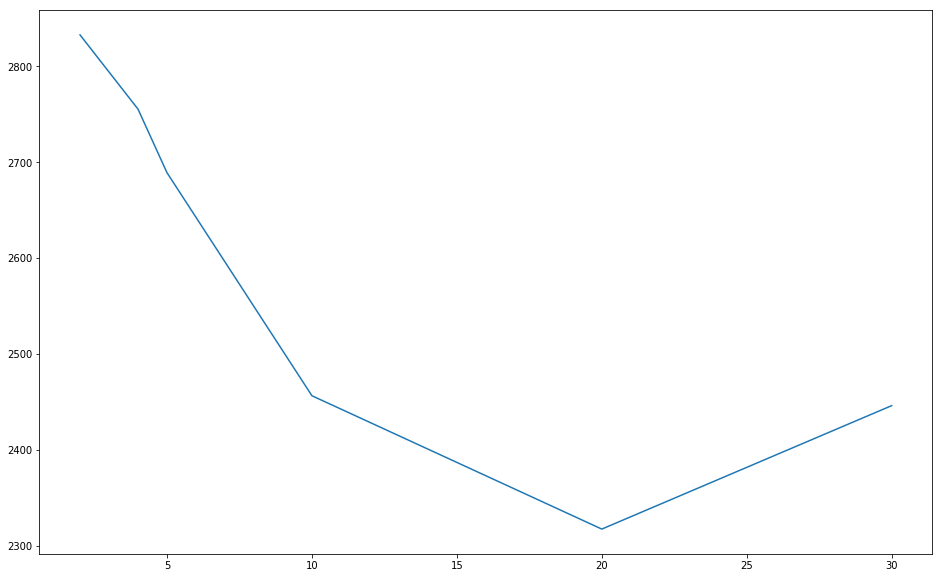

In [4]:
#maxDepth에 대한 관계 확인하기

params=[2,4,5,10,20,30] # 계속 줄어드는 그래프, 반등이 일어나지 않음. 값을 키우도록 한다.
##params=[10, 20,50, 100, 200]
##requirement failed: DecisionTree currently only supports maxDepth <= 30

metrics=[evaluate_rf(train_data_dt, test_data_dt, 10, param, 32) for param in params]
print(params)
print(metrics)
plot(params, metrics)
fig=matplotlib.pyplot.gcf()
fig.set_size_inches(16,10)

##### ∴ Optimized Value 'maxDepth' is 20

#### 1-2-3) Parameter : maxBins

[20, 32, 50, 64, 128]
[2447.1328707074404, 2440.3838711101776, 2252.6583608582278, 2259.2497746443332, 1961.7608565949204]


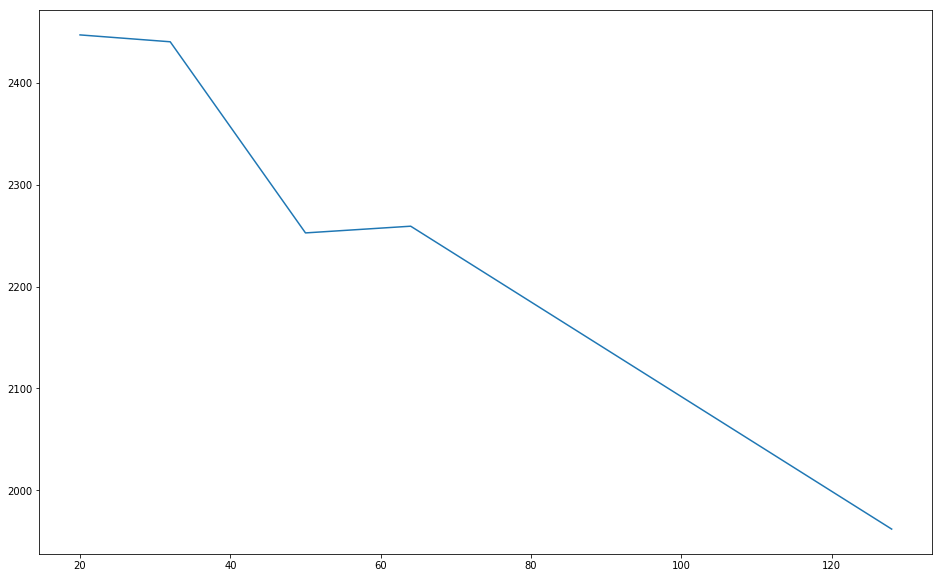

In [5]:
#maxBins에 대한 관계 확인하기, maxDepth=20

params=[20,32, 50, 64, 128]
metrics=[evaluate_rf(train_data_dt, test_data_dt, 10, 20, param) for param in params]
print(params)
print(metrics)
plot(params, metrics)
fig=matplotlib.pyplot.gcf()
fig.set_size_inches(16,10)

##### ∴ Optimized Value 'maxBins' is 50

In [5]:
#maxBins에 대한 관계 확인하기, maxDepth=10, more test

params=[32, 64, 128, 256, 512]
metrics=[evaluate_rf(train_data_dt, test_data_dt, 10, 20, param) for param in params]
print(params)
print(metrics)
plot(params, metrics)
fig=matplotlib.pyplot.gcf()
fig.set_size_inches(16,10)


KeyboardInterrupt: 

##### WARN RandomForest: Tree learning is using approximately 268437192 bytes per iteration, which exceeds requested limit maxMemoryUsage=268435456
더 많은 저장공간(bins)에 대해서는 에러발생으로 인한 테스트 중단

### 1-3) Optimized Random Forest Model

In [4]:
#optimized Model using Random Forest
op_model_rf=RandomForest.trainRegressor(train_data_dt, categoricalFeaturesInfo={}, numTrees=10, featureSubsetStrategy="auto",
                                    impurity='variance', maxDepth=20, maxBins=50)
preds_rf=op_model_rf.predict(test_data_dt.map(lambda p:p.features))
actual_rf=test_data_dt.map(lambda p:p.label)
tp_rf=actual_rf.zip(preds_rf)
rmse_rf=np.sqrt(tp_rf.map(lambda p:squared_error(p[0], p[1])).mean())
print(rmse_rf)

2277.00781013


### ∴ Optimized Random Forest Model
RMSE(Root Mean Squared Error)가 최대 2832 -> 2277까지 줄어든 것을 확인할 수 있다

---
## 2) Gradient Boosted Tree
- DecisionTree를 반복적으로 Training
- 각 Instance값과 값을 계속 비교하면서, 오차를 줄여나감
- 'max-depth' 또는 'max_leaf_nodes'로 Tree estimator의 강도를 결정
- Boosting은 약한 estimator로 천천히 학습을 함이 좋으므로 depth가 4이하, leaf-node 수가 15가 넘는 경우는 드뭄
- (하지만 큰 tree를 그냥 제외시키지 말고 5 level 이상 깊이의 tree도 데이터 복잡도에 따라 시험해 보도록)
- learning_rate가 크면 빨리 오류를 보정하지만 overfitting 가능성도 큼
- learning_rate를 작게 하고 n_estimators를 크게 하면 overfitting 않고 차분히 학습하여 좋지만 training 시간이 많이 걸리는 것이 단점.

#### Boosting
- Bagging과 유사하게, 초기 샘플 데이터를 조작하여 다수의 분류기를 생성하는 기법중 하나
- 순차적(sequencial)한 방법
- 이전 분류기의 학습을 토대로 다음 분류기의 학습 데이터 샘플 가중치를 조정해 학습
    (bagging의 경우 분류기들이 학습시에 상호 영향을 주지 않고, 마지막에 그 결과를 종합하는 방법)
- 타 앙상블(ensemble)모형과 같이 분류결과에 대한 해석이 불가능함


- [참고] 꿈쟁이 http://blog.naver.com/gksshdk8003/220911836024
- [참고] spark http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.tree.GradientBoostedTrees
- [참고] https://nbviewer.jupyter.org/github/hyunblee/ISLR-with-Python/blob/master/Ch8-Tree%20based%20Methods/Ch8_Tree_based_Methods.ipynb

### 2-1) Model training Function and Parameters

##### trainRegressor(data, categoricalFeaturesInfo, loss='leastSquaresError', numIterations=100, learningRate=0.1, maxDepth=3, maxBins=32)


###### Parameters:	
* data – Training dataset: RDD of LabeledPoint. Labels are real numbers.
* categoricalFeaturesInfo – Map storing arity of categorical features. An entry (n -> k) indicates that feature n is categorical with k categories indexed from 0: {0, 1, ..., k-1}.
* loss – Loss function used for minimization during gradient boosting. Supported values: “logLoss”, “leastSquaresError”, “leastAbsoluteError”. (default: “leastSquaresError”)
* numIterations – Number of iterations of boosting. (default: 100)
* learningRate – Learning rate for shrinking the contribution of each estimator. The learning rate should be between in the interval (0, 1]. (default: 0.1)
* maxDepth – Maximum depth of tree (e.g. depth 0 means 1 leaf node, depth 1 means 1 internal node + 2 leaf nodes). (default: 3)
* maxBins – Maximum number of bins used for splitting features. DecisionTree requires maxBins >= max categories. (default: 32)

### 2-2) Optimization of Gradient Boosted Tree Model

In [5]:
# Gradient Boosted Tree 테스트 메소드
def evaluate_gb(train, test, loss, numIterations, learningRate, maxDepth, maxBins):
    model=GradientBoostedTrees.trainRegressor(train, categoricalFeaturesInfo={}, loss=loss, numIterations=numIterations,learningRate=learningRate, maxDepth=maxDepth, maxBins=maxBins)
    preds=model.predict(test.map(lambda p:p.features))
    actual=test.map(lambda p:p.label)
    tp=actual.zip(preds)
    rmse=np.sqrt(tp.map(lambda p:squared_error(p[0], p[1])).mean())
    return rmse

['logLoss', 'leastSquaresError', 'leastAbsoluteError']
[2664.5750880977794, 2106.1613560149626, 2664.2259952362701]


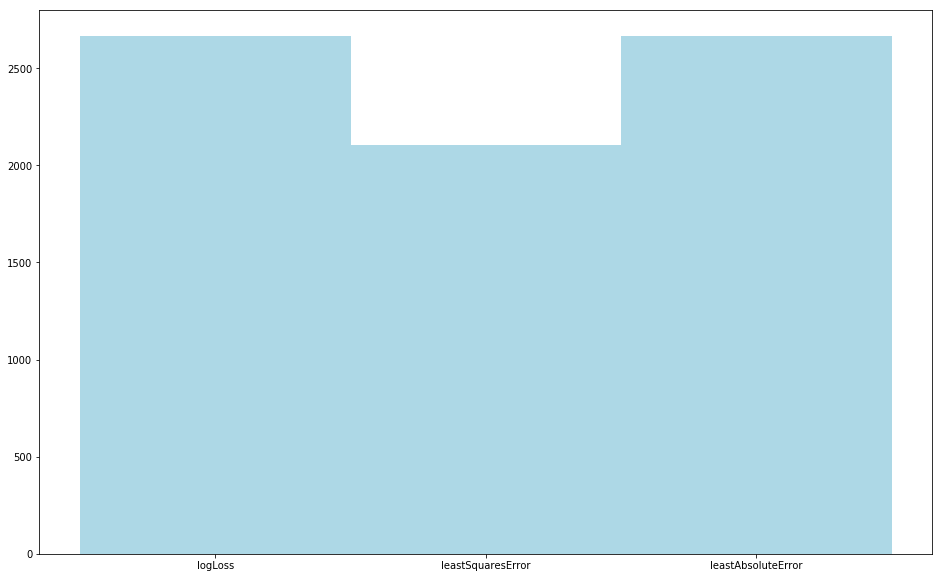

In [26]:
#loss method
params=["logLoss", "leastSquaresError", "leastAbsoluteError"]
metrics=[evaluate_gb(train_data_dt, test_data_dt, loss=param,
                     numIterations=100, learningRate=0.1, maxDepth=3, maxBins=32) for param in params]
print(params)
print(metrics)
#plot(params, metrics) # 막대 실행 구문을 변경해야함
x_axis=np.array(params)
y_axis=np.array(metrics)
pos=np.arange(len(x_axis))
width=1.0

ax=plt.axes()
ax.set_xticks(pos+width-1)
ax.set_xticklabels(x_axis)
plt.bar(pos, y_axis, width, color='lightblue')
#plt.xticks(rotation=30)
fig=matplotlib.pyplot.gcf()
fig.set_size_inches(16,10)

##### ∴ Optimized 'loss' Method is leastSquaresError(default value)

[2, 3, 4, 5, 10]
[2271.3569052112766, 2155.355973166591, 2011.9200322148831, 1926.179966638339, 1768.2787748955723]


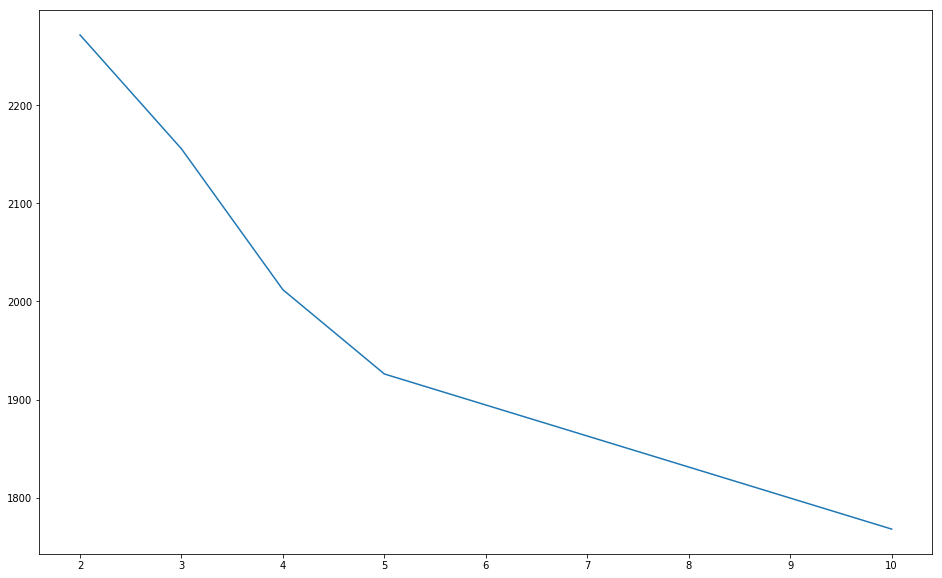

In [6]:
#maxDepth
params=[2, 3, 4, 5,10]
metrics=[evaluate_gb(train_data_dt, test_data_dt, loss="leastSquaresError",
                     numIterations=100, learningRate=0.1, maxDepth=param, maxBins=32) for param in params]
print(params)
print(metrics)
plot(params, metrics)
fig=matplotlib.pyplot.gcf()
fig.set_size_inches(16,10)

##### ∴ Optimized 'maxDepth' is 5

[16, 32, 64, 128, 256]
[2420.1486959406457, 2155.355973166591, 1823.6361743287355, 1706.1309994518349, 1708.9554675073919]


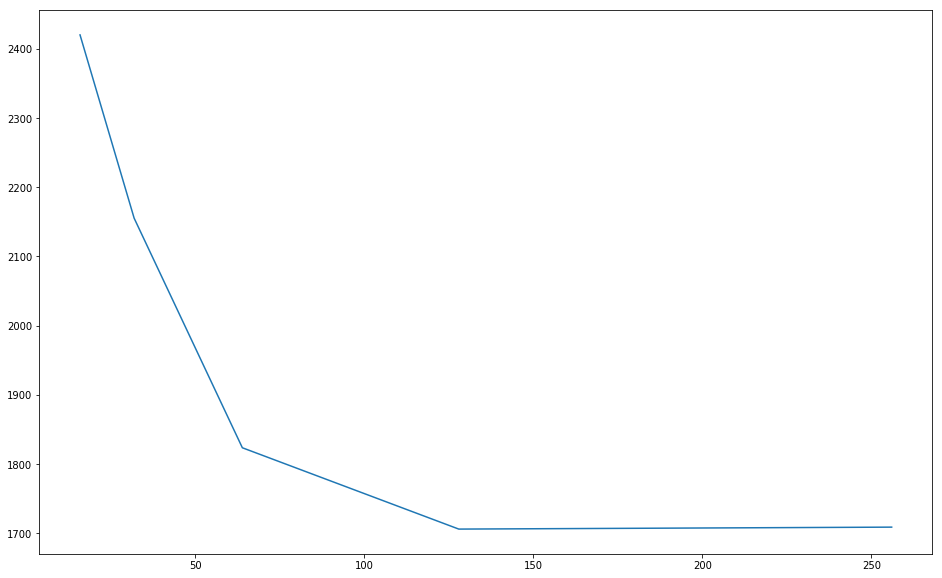

In [7]:
#maxBins
params=[16, 32, 64, 128, 256]
metrics=[evaluate_gb(train_data_dt, test_data_dt, loss="leastSquaresError",
                     numIterations=100, learningRate=0.1, maxDepth=3, maxBins=param) for param in params]
print(params)
print(metrics)
plot(params, metrics)
fig=matplotlib.pyplot.gcf()
fig.set_size_inches(16,10)

##### ∴ Optimized 'maxBins' is 128

[25, 50, 100, 150, 200]
[2386.7514454350503, 2270.9412234756705, 2114.5623146933617, 2028.204204828819, 1963.2903687254491]


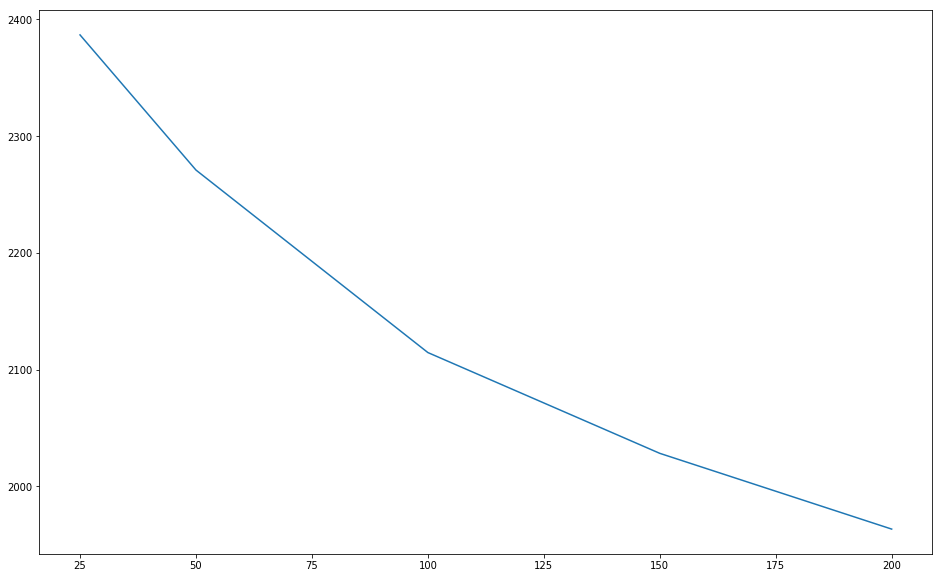

In [7]:
#numIterations, 나머지 값들은 default값과 동일하게 설정한다.
params=[25, 50, 100, 150, 200] # iterations 값을 500으로 했더니 에러 발생
metrics=[evaluate_gb(train_data_dt, test_data_dt, loss='leastSquaresError',
                     numIterations=param, learningRate=0.1, maxDepth=3, maxBins=32) for param in params]
print(params)
print(metrics)
plot(params, metrics)
fig=matplotlib.pyplot.gcf()
fig.set_size_inches(16,10)

##### ∴ Optimized Value 'numIterations' is 200 
하지만 실행기간이 너무 오래 걸리므로, 최적화 모델에서만 200으로 값을 설정하기로

[0.01, 0.1, 0.5]
[2417.8722639254147, 1963.2903687254491, 1629.8590611873965]


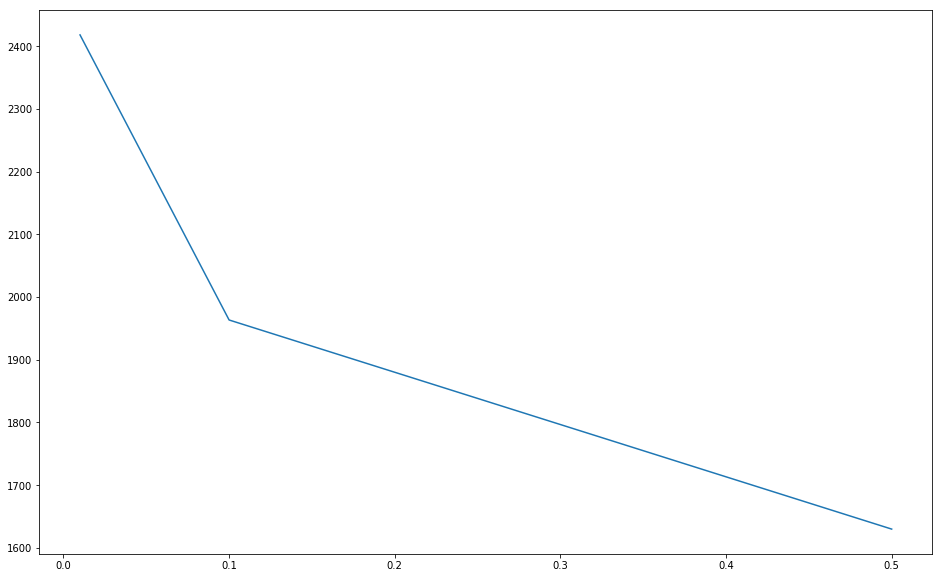

In [6]:
#learning Rate
params=[0.01, 0.1, 0.5]
metrics=[evaluate_gb(train_data_dt, test_data_dt, loss="leastSquaresError",
                     numIterations=200, learningRate=param, maxDepth=3, maxBins=32) for param in params]
print(params)
print(metrics)
plot(params, metrics)
fig=matplotlib.pyplot.gcf()
fig.set_size_inches(16,10)

##### ∴ Optimized 'Learning Rate' is 0.1
실상 Learning Rate는 numIterations와 Tradeoff되는 경향이 있으므로, 나중에 다시 확인할 것

In [11]:
op_model_gb=GradientBoostedTrees.trainRegressor(train_data_dt, categoricalFeaturesInfo={}, loss='leastSquaresError', numIterations=200,learningRate=0.1, maxDepth=5, maxBins=128)
preds_gb=op_model_gb.predict(test_data_dt.map(lambda p:p.features))
actual_gb=test_data_dt.map(lambda p:p.label)
tp=actual_gb.zip(preds_gb)
rmse=np.sqrt(tp.map(lambda p:squared_error(p[0], p[1])).mean())
print(rmse)

1171.22859135


In [14]:
tp.take(30)

[(78.0, -303.3584648111223),
 (393.0, 270.0825563552583),
 (452.0, 639.4713457291039),
 (467.0, 216.00117733961477),
 (506.0, 489.6991891865858),
 (490.0, 454.2120817750318),
 (305.0, 64.79281369587291),
 (2683.0, 6996.032180646145),
 (4785.0, 6806.020256946398),
 (6092.0, 6383.471058314861),
 (6518.0, 10468.116259365719),
 (5027.0, 5821.875599055999),
 (5554.0, 6464.9908751079065),
 (2136.0, 2020.3469215566192),
 (2009.0, 2852.464541299228),
 (2600.0, 4492.085719472911),
 (4549.0, 3966.7875455215353),
 (4952.0, 4137.313366314702),
 (4981.0, 4717.400567940113),
 (4259.0, 6299.146625864737),
 (1240.0, 2032.774821627379),
 (2570.0, 2579.4940765381884),
 (4861.0, 4362.858911034959),
 (5370.0, 4909.799301602768),
 (4321.0, 4074.641115787377),
 (4476.0, 3754.037687141362),
 (433.0, 127.55042010720088),
 (405.0, 552.1189109504963),
 (683.0, 805.129471389325),
 (2160.0, 1179.9521562166249)]

### ∴ Optimized Gradient Boosted Tree Model
RMSE(Root Mean Squared Error)가 최대 2664 -> 1171까지 줄어든 것을 확인할 수 있다

---
# Conclusion
- DecisionTree와 연관이 있는 RandomForest, GradientBoostedTree 모델을 학습하였다.
- 일반적인 LinearRegression 모델들보다 Tree 모델이 정확도가 높은 것을 확인하였다.
- 내부에서 Bins나 Depth의 수치가 커질수록, 내부 메모리 소모가 심한것을 확인하였다.
- LinearRegressionWithSGD, DecisionTree 모델보다 학습 시간이 길었다.
- 적절한 값 조정을 통한 Optimizing을 성공하였다.